# Counting billionaires

It's been a real long time since I did any MLE so I'm going to work through the example code before attempting the exercises

In [1]:
import pandas as pd
import numpy as np
from numpy import exp
from scipy import stats
from scipy.special import factorial
from statsmodels.api import Poisson
from statsmodels.discrete.discrete_model import Probit
import altair as alt

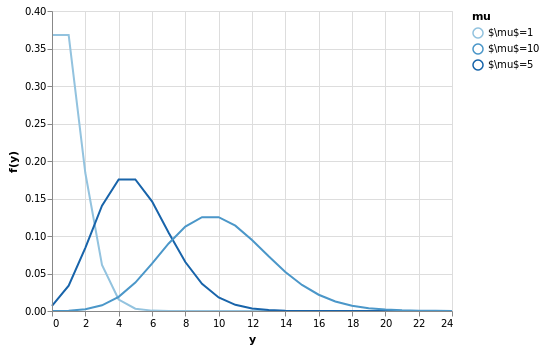

In [2]:
poisson_pmf = lambda y, u: u**y / factorial(y) * exp(-u)
df = pd.DataFrame({'y': range(0, 25)})
for u in [1, 5, 10]:
    df[f'$\mu$={u}'] = df['y'].apply(lambda x: poisson_pmf(x, u))
df = df.melt(id_vars=('y'))
alt.Chart(df).mark_line().encode(x='y:Q', y=alt.Y('value:Q', title='f(y)'), color=alt.Color('variable:O', title='mu'))
# No pretty LaTeX in altair, maybe when https://github.com/vega/vega/issues/898 is closed

In [3]:
df = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/mle/fp.dta')
df.head()

,country,ccode,year,cyear,numbil,numbil0,numbilall,netw,netw0,netwall,...,gattwto08,mcapbdol,mcapbdol08,lnmcap08,topintaxnew,topint08,rintr,noyrs,roflaw,nrrents
0,United States,2.0,1990.0,21990.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,3060.000000,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
1,United States,2.0,1991.0,21991.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4090.000000,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
2,United States,2.0,1992.0,21992.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4490.000000,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
3,United States,2.0,1993.0,21993.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,5136.198730,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN
4,United States,2.0,1994.0,21994.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,5067.016113,11737.599609,9.370638,39.799999,39.799999,4.988405,20.0,1.61,NaN


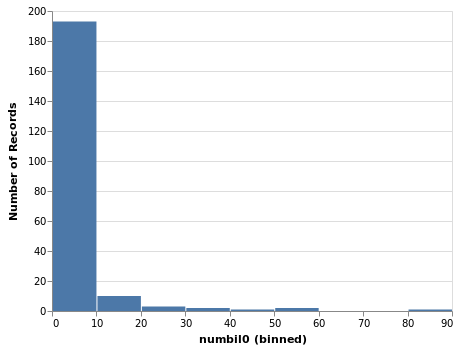

In [4]:
bil_08_mask = (
    (df['country'] != 'United States') &
    (df['year'] == 2008)
)
numbil_08 = df.loc[bil_08_mask, 'numbil0'].copy().to_frame()
alt.Chart(numbil_08).mark_bar().encode(x=alt.X('numbil0:Q', bin=True), y='count()')

Standard poisson:

$$f(y) = \frac{\mu^{y}}{y!} e^{-\mu}, \qquad y = 0, 1, 2, \ldots, \infty$$

Poisson regression model: 

$$f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty . \tag{1}$$

$$\text{where}\ \mu_i
     = \exp(\mathbf{x}_i' \boldsymbol{\beta})
     = \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik})
     $$

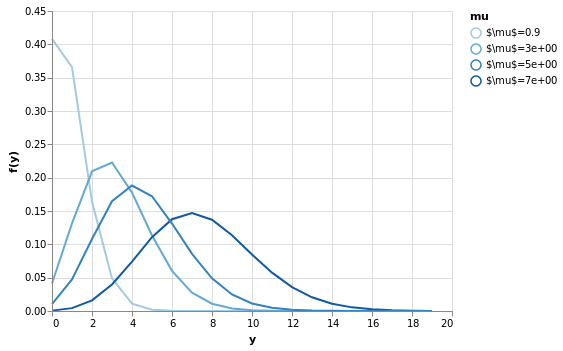

In [5]:
df = pd.DataFrame({'y': range(0, 20)})

# Create some parameters
beta = np.array([0.26, 0.18, 0.25, -0.1, -0.22]).T
# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]
for X in datasets:
    u = exp(X @ beta)
    df[f'$\mu$={u:.1}'] = df['y'].apply(lambda x: poisson_pmf(x, u))
df = df.melt(id_vars=('y'))
alt.Chart(df).mark_line().encode(x='y:Q', y=alt.Y('value:Q', title='f(y)'), color=alt.Color('variable:O', title='mu'))

In [6]:
class PoissonRegression:
    
    def __init__(self, y, x, beta):
        self.y, self.x, self.beta = y, x, beta
        self.n, self.k = x.shape

    def mu(self):
        return exp(self.x @ self.beta.T)
    
    def log_like(self):
        y = self.y
        mu = self.mu()
        return np.sum(y * np.log(mu) - mu - np.log(factorial(y)))

    def g(self):
        mu, y, x, k = self.mu(), self.y, self.x, self.k
        return ((y - mu) @ x).reshape(k, 1)
    
    def h(self):
        x, mu = self.x, self.mu()
        return -(mu * x.T @ x)

    
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):
    i = 0
    error = 100 + tol # make sure we don't start below tolerance
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))
    
    while np.any(error > tol) and i < max_iter:
        h, g = model.h(), model.g()
        beta_update = model.beta - (np.linalg.inv(h) @ g).T
        error = beta_update - model.beta
        model.beta = beta_update.flatten()
        
        if display:
            beta_list = [f'{t:.3}' for t in list(model.beta)]
            update = f'{i:<13}{model.log_like():<16.8}{beta_list}'
            print(update)
        
        i += 1
    
    print(f'Number of iterations: {i}')
    print(f'beta_hat = {model.beta}')
    return model.beta

In [7]:
x = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial betas
init_beta = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, x, beta=init_beta)

# Use newton_raphson to find the MLE
beta_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 6
beta_hat = [-6.07848205  0.93340226  0.84329625]


In [8]:
x = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, x).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Mar 2019   Pseudo R-squ.:                  0.2546
Time:                        15:33:28   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
                                        LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

In [9]:
df = (
    pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/mle/fp.dta')
    .loc[lambda x: x['year'] == 2008]
    .copy()
    .assign(const=1)
)

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

In [10]:
poisson_reg = Poisson(df['numbil0'], df[reg1], missing='drop').fit(cov_tyupe='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sat, 30 Mar 2019   Pseudo R-squ.:                  0.8574
Time:                        15:33:29   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      0.638    -45.517      0.000     -30.300     -27.799
lngdppc        1.0839      0.

# Exercise 1

Suppose we wanted to estimate the probability of an event $y_i$ occurring, given some observations

We could use a probit regression model, where the pmf of $y_i$ is

$$ f(y_i; \boldsymbol{\beta}) = \mu_i^{y_i} (1-\mu_i)^{1-y_i}, \quad y_i = 0,1 \\ \text{where} \quad \mu_i = \Phi(\mathbf{x}_i' \boldsymbol{\beta})$$

$\Phi$ represents the *cumulative normal distribution* and constrains the predicted $y_i$ to be between 0 and 1 (as required for a probability)

$\beta$ is a vector of coefficients

Following the example in the lecture, write a class to represent a Probit model

To begin, find the log-likelihood function and derive the gradient and Hessian

The `scipy` module `stats.norm` contains the functions needed to compute the cmf and pmf of the normal distribution

In [11]:
class ProbitRegression:
    
    def __init__(self, y, x, beta):
        self.y, self.x, self.beta = y, x, beta
        self.n, self.k = x.shape
    
    def mu(self):
        return stats.norm.cdf(self.x @ self.beta.T)
    
    def phi(self):
        return stats.norm.pdf(self.x @ self.beta.T)
    
    def log_like(self):
        y, mu = self.y, self.mu()
        return np.sum(y * np.log(mu) + (1-y) * np.log(1 - mu))
    
    def g(self):
        x, y, mu, phi = self.x, self.y, self.mu(), self.phi()
        return np.sum((x.T * y * phi / mu - x.T * (1 - y) * phi / (1 - mu)), axis=1)
    
    def h(self):
        x, y, mu, phi, beta = self.x, self.y, self.mu(), self.phi(), self.beta
        a = (phi + (x @ beta.T) * mu) / mu**2
        b = (phi - (x @ beta.T) * (1 - mu)) / (1 - mu)**2
        return -(phi * (y * a + (1 - y) * b) * x.T) @ x
    

# Exercise 2

Use the following dataset and initial values of $\beta_0$ to estimate the MLE with the Newton-Raphson algorithm developed earlier in the lecture

$$
\mathbf{X} =
\begin{bmatrix}
1 & 2 & 4 \\
1 & 1 & 1 \\
1 & 4 & 3 \\
1 & 5 & 6 \\
1 & 3 & 5
\end{bmatrix}
\quad
y =
\begin{bmatrix}
1 \\
0 \\
1 \\
1 \\
0
\end{bmatrix}
\quad
\boldsymbol{\beta}_{(0)} =
\begin{bmatrix}
0.1 \\
0.1 \\
0.1
\end{bmatrix}
$$

Verify your results with `statsmodels` - you can import the Probit function with the following import statement

```python
from statsmodels.discrete.discrete_model import Probit
```

Note that the simple Netwon-Raphson algorithm developed in this lecture is very sensitive to initial values, and therefore you may fail to acheive convergence with different starting values

In [12]:
x = np.array([[1, 2, 4],
              [1, 1, 1],
              [1, 4, 3],
              [1, 5, 6],
              [1, 3, 5]])

y = np.array([1, 0, 1, 1, 0])

beta = np.array([0.1, 0.1, 0.1])

prob = ProbitRegression(y, x, beta)

newton_raphson(prob)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -2.3796884      ['-1.34', '0.775', '-0.157']
1            -2.3687526      ['-1.53', '0.775', '-0.0981']
2            -2.3687294      ['-1.55', '0.778', '-0.0971']
3            -2.3687294      ['-1.55', '0.778', '-0.0971']
Number of iterations: 4
beta_hat = [-1.54625858  0.77778952 -0.09709757]


array([-1.54625858,  0.77778952, -0.09709757])

In [13]:
stats_probit = Probit(y, x).fit()
print(stats_probit.summary())

Optimization terminated successfully.
         Current function value: 0.473746
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                    5
Model:                         Probit   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sat, 30 Mar 2019   Pseudo R-squ.:                  0.2961
Time:                        15:33:29   Log-Likelihood:                -2.3687
converged:                       True   LL-Null:                       -3.3651
                                        LLR p-value:                    0.3692
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5463      1.866     -0.829      0.407      -5.204       2.111
x1             0.7778      0.